# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

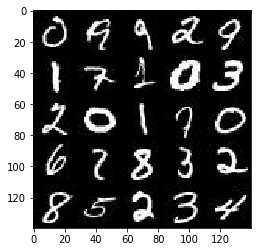

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

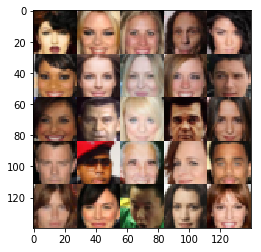

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [4]:
mnist_images.shape

(25, 28, 28, 3)

In [5]:
mnist_images.shape[-3:]

(28, 28, 3)

In [6]:
print(mnist_images[0].min())
print(mnist_images[0].max())

0.0
255.0


In [7]:
#according to the description below 
#"The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images."
mnist_dataset_temp = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
batches = mnist_dataset_temp.get_batches(128)
for imgs in batches:
    print(imgs)
    break

[[[[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [-0.5       ]
   [-0.5       ]
   [-0.5       ]]

  [[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [-0.5       ]
   [-0.5       ]
   [-0.5       ]]

  [[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [-0.5       ]
   [-0.5       ]
   [-0.5       ]]

  ..., 
  [[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [-0.5       ]
   [-0.5       ]
   [-0.5       ]]

  [[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [-0.5       ]
   [-0.5       ]
   [-0.5       ]]

  [[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [-0.5       ]
   [-0.5       ]
   [-0.5       ]]]


 [[[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [-0.5       ]
   [-0.5       ]
   [-0.5       ]]

  [[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [-0.5       ]
   [-0.5       ]
   [-0.5       ]]

  [[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [-0.5       ]
   [-0.5 

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [9]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')
    
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    drop_out = 0.75
    #input dim will be that of generator output dim, i.e, 28x28xout_chan_dim(3)
    with tf.variable_scope('discriminator', reuse=reuse):
        #conv layer1
        x1 = tf.layers.conv2d(images,64, (5,5), strides=(2,2), padding='same', kernel_initializer=None) #setting kernel initializer to None will make it generate a new Glorot Uniform (Xavier) initializer
        x1 = tf.nn.dropout(x=x1, keep_prob=drop_out) #adding drop out to experiment if it improves output
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        #conv layer2
        x2 = tf.layers.conv2d(relu1, 128, (5,5), strides=(2,2), padding='same', kernel_initializer=None)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        bn2 = tf.nn.dropout(x=bn2, keep_prob=drop_out) #adding drop out to experiment if it improves output
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
         #conv layer3
        x3 = tf.layers.conv2d(relu2, 256, (5,5), strides=(2,2), padding='same', kernel_initializer=None)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        bn3 = tf.nn.dropout(x=bn3, keep_prob=drop_out)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        #flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    drop_out = 0.75
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        #Input
        x1 = tf.layers.dense(z, 7*7*512)
        # reshape it 
        reshaped1 = tf.reshape(x1, (-1,7,7,512))
        bn1 = tf.layers.batch_normalization(reshaped1, training=is_train)
        bn1 = tf.nn.dropout(bn1, keep_prob=drop_out)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 7x7x64 is the output (chngd frm 128)
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=(2,2), padding='same', kernel_initializer=None)
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        bn2 = tf.nn.dropout(bn2, keep_prob=drop_out)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=(2,2), padding='same', kernel_initializer=None)
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        bn3 = tf.nn.dropout(bn3, keep_prob=drop_out)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 28x28x16
        
        #logits
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=(1,1), padding='same', kernel_initializer=None)
        # should be 28x28x3
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_out = generator(z=input_z, out_channel_dim=out_channel_dim, is_train=True)
    discriminator_out_real, discriminator_logits_real = discriminator(images=input_real, reuse=False)
    discriminator_out_z, discriminator_logits_z = discriminator(images = generator_out, reuse=True)
    
    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_out_real)*0.9))
    
    discriminator_loss_z = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_z, labels = tf.zeros_like(discriminator_out_z)))
    
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_z, labels=tf.ones_like(discriminator_out_z)))
    
    discriminator_loss_total = discriminator_loss_real + discriminator_loss_z
    
    return discriminator_loss_total, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_variables = tf.trainable_variables()
    discriminator_variables = [var for var in t_variables if var.name.startswith('discriminator')]
    generator_variables = [var for var in t_variables if var.name.startswith('generator')]
    
    #optimizers
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_variables)
        generator_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_variables)
    
    return discriminator_optimizer, generator_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        
    losses = []
    steps = 0
    print_every=10
    show_every=100
    
    image_width, image_height, image_channel_depth  = data_shape[-3:]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channel_depth, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z,out_channel_dim=image_channel_depth)
    disc_optimizer, gen_optimizer = model_opt(disc_loss, gen_loss, lr, beta1=beta1)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                #multiplying by 2 since the values are preprocessed to be between -0.5 to 0.5
                batch_images = 2 * batch_images
                
                #random noise sample
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                #running optimizers
                _ = sess.run(disc_optimizer, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                for i in range(5):
                    _ = sess.run(gen_optimizer, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                #print stats
                if steps % print_every ==0:
                    disc_loss_train = disc_loss.eval({input_real: batch_images, input_z: batch_z})
                    gen_loss_train = gen_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(disc_loss_train),
                          "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                    losses.append((disc_loss_train, gen_loss_train))
                    
                #show images
                if steps% show_every ==0:
                    show_generator_output(sess, 16, input_z, image_channel_depth, data_image_mode)
        
        #each epoch
        saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.6772... Generator Loss: 0.2516
Epoch 1/2... Discriminator Loss: 1.9330... Generator Loss: 0.6871
Epoch 1/2... Discriminator Loss: 2.0606... Generator Loss: 0.5534
Epoch 1/2... Discriminator Loss: 2.5067... Generator Loss: 0.9141
Epoch 1/2... Discriminator Loss: 1.9835... Generator Loss: 0.6289
Epoch 1/2... Discriminator Loss: 2.0411... Generator Loss: 0.5205
Epoch 1/2... Discriminator Loss: 1.9685... Generator Loss: 0.8842
Epoch 1/2... Discriminator Loss: 1.9654... Generator Loss: 0.5146
Epoch 1/2... Discriminator Loss: 1.7971... Generator Loss: 0.6298
Epoch 1/2... Discriminator Loss: 1.9834... Generator Loss: 0.4030


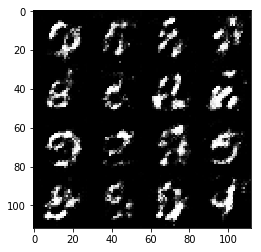

Epoch 1/2... Discriminator Loss: 1.7304... Generator Loss: 0.6364
Epoch 1/2... Discriminator Loss: 1.8708... Generator Loss: 0.5078
Epoch 1/2... Discriminator Loss: 1.8542... Generator Loss: 0.7046
Epoch 1/2... Discriminator Loss: 1.6794... Generator Loss: 0.7100
Epoch 1/2... Discriminator Loss: 1.7832... Generator Loss: 0.9092
Epoch 1/2... Discriminator Loss: 1.8050... Generator Loss: 0.7657
Epoch 1/2... Discriminator Loss: 1.8687... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 1.7768... Generator Loss: 0.5122
Epoch 1/2... Discriminator Loss: 1.6485... Generator Loss: 0.6525
Epoch 1/2... Discriminator Loss: 1.6764... Generator Loss: 0.8974


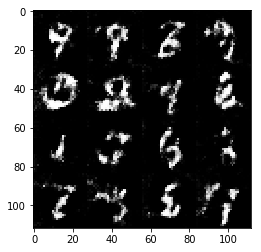

Epoch 1/2... Discriminator Loss: 1.5931... Generator Loss: 0.5532
Epoch 1/2... Discriminator Loss: 1.6560... Generator Loss: 0.6904
Epoch 1/2... Discriminator Loss: 1.6910... Generator Loss: 0.6680
Epoch 1/2... Discriminator Loss: 1.5909... Generator Loss: 0.7366
Epoch 1/2... Discriminator Loss: 1.7825... Generator Loss: 0.6802
Epoch 1/2... Discriminator Loss: 1.6195... Generator Loss: 0.7990
Epoch 1/2... Discriminator Loss: 1.6362... Generator Loss: 0.7388
Epoch 1/2... Discriminator Loss: 1.5091... Generator Loss: 0.7986
Epoch 1/2... Discriminator Loss: 1.5343... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 1.4804... Generator Loss: 0.7034


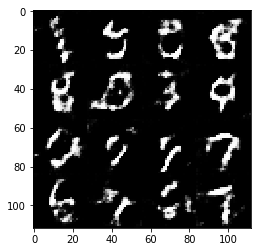

Epoch 1/2... Discriminator Loss: 1.4811... Generator Loss: 0.6422
Epoch 1/2... Discriminator Loss: 1.6366... Generator Loss: 0.7947
Epoch 1/2... Discriminator Loss: 1.6459... Generator Loss: 0.9708
Epoch 1/2... Discriminator Loss: 1.5576... Generator Loss: 0.6922
Epoch 1/2... Discriminator Loss: 1.5220... Generator Loss: 0.7048
Epoch 1/2... Discriminator Loss: 1.6035... Generator Loss: 0.6957
Epoch 1/2... Discriminator Loss: 1.5807... Generator Loss: 0.6486
Epoch 1/2... Discriminator Loss: 1.4461... Generator Loss: 0.6379
Epoch 1/2... Discriminator Loss: 1.4949... Generator Loss: 0.7494
Epoch 1/2... Discriminator Loss: 1.6049... Generator Loss: 0.5380


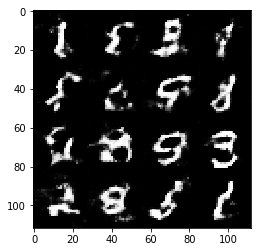

Epoch 1/2... Discriminator Loss: 1.4874... Generator Loss: 0.6610
Epoch 1/2... Discriminator Loss: 1.5662... Generator Loss: 0.7259
Epoch 1/2... Discriminator Loss: 1.5127... Generator Loss: 0.8334
Epoch 1/2... Discriminator Loss: 1.4765... Generator Loss: 0.7717
Epoch 1/2... Discriminator Loss: 1.4332... Generator Loss: 0.6861
Epoch 1/2... Discriminator Loss: 1.5286... Generator Loss: 0.7156
Epoch 1/2... Discriminator Loss: 1.5892... Generator Loss: 0.7152
Epoch 1/2... Discriminator Loss: 1.4730... Generator Loss: 0.6245
Epoch 1/2... Discriminator Loss: 1.4625... Generator Loss: 0.7773
Epoch 1/2... Discriminator Loss: 1.4496... Generator Loss: 0.9908


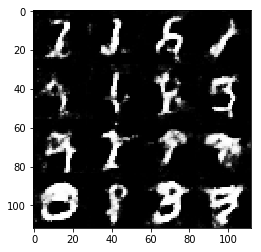

Epoch 1/2... Discriminator Loss: 1.4307... Generator Loss: 0.7288
Epoch 1/2... Discriminator Loss: 1.4623... Generator Loss: 0.7816
Epoch 1/2... Discriminator Loss: 1.5512... Generator Loss: 0.6197
Epoch 1/2... Discriminator Loss: 1.4520... Generator Loss: 0.7457
Epoch 1/2... Discriminator Loss: 1.4798... Generator Loss: 0.6838
Epoch 1/2... Discriminator Loss: 1.5511... Generator Loss: 0.7543
Epoch 1/2... Discriminator Loss: 1.5252... Generator Loss: 0.8087
Epoch 1/2... Discriminator Loss: 1.4626... Generator Loss: 0.7508
Epoch 1/2... Discriminator Loss: 1.5015... Generator Loss: 0.6971
Epoch 1/2... Discriminator Loss: 1.4722... Generator Loss: 0.7005


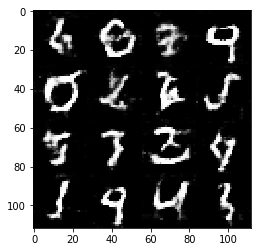

Epoch 1/2... Discriminator Loss: 1.4472... Generator Loss: 0.6841
Epoch 1/2... Discriminator Loss: 1.4629... Generator Loss: 0.8389
Epoch 1/2... Discriminator Loss: 1.5126... Generator Loss: 0.7326
Epoch 1/2... Discriminator Loss: 1.4495... Generator Loss: 0.7334
Epoch 1/2... Discriminator Loss: 1.4926... Generator Loss: 0.7889
Epoch 1/2... Discriminator Loss: 1.4710... Generator Loss: 0.7200
Epoch 1/2... Discriminator Loss: 1.4781... Generator Loss: 0.6094
Epoch 1/2... Discriminator Loss: 1.4961... Generator Loss: 0.8639
Epoch 1/2... Discriminator Loss: 1.3511... Generator Loss: 0.8566
Epoch 1/2... Discriminator Loss: 1.4999... Generator Loss: 0.6968


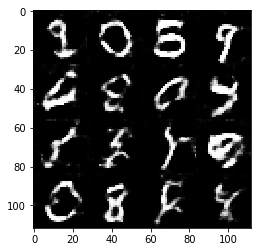

Epoch 1/2... Discriminator Loss: 1.4689... Generator Loss: 0.6484
Epoch 1/2... Discriminator Loss: 1.5825... Generator Loss: 0.8811
Epoch 1/2... Discriminator Loss: 1.5119... Generator Loss: 0.6988
Epoch 1/2... Discriminator Loss: 1.5055... Generator Loss: 0.7548
Epoch 1/2... Discriminator Loss: 1.4784... Generator Loss: 0.6875
Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 0.7639
Epoch 1/2... Discriminator Loss: 1.4618... Generator Loss: 0.7111
Epoch 1/2... Discriminator Loss: 1.4273... Generator Loss: 0.7060
Epoch 1/2... Discriminator Loss: 1.4922... Generator Loss: 0.8399
Epoch 1/2... Discriminator Loss: 1.4555... Generator Loss: 0.6115


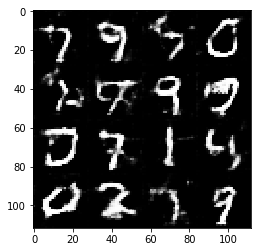

Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 0.8331
Epoch 1/2... Discriminator Loss: 1.5003... Generator Loss: 0.8518
Epoch 1/2... Discriminator Loss: 1.4214... Generator Loss: 0.8752
Epoch 1/2... Discriminator Loss: 1.5504... Generator Loss: 0.6570
Epoch 1/2... Discriminator Loss: 1.4686... Generator Loss: 0.7652
Epoch 1/2... Discriminator Loss: 1.3841... Generator Loss: 0.7951
Epoch 1/2... Discriminator Loss: 1.4636... Generator Loss: 0.7760
Epoch 1/2... Discriminator Loss: 1.4877... Generator Loss: 0.7707
Epoch 1/2... Discriminator Loss: 1.4346... Generator Loss: 0.6648
Epoch 1/2... Discriminator Loss: 1.4579... Generator Loss: 0.6554


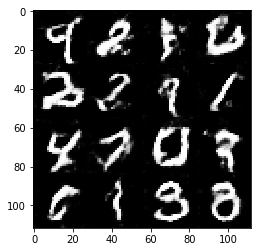

Epoch 1/2... Discriminator Loss: 1.4234... Generator Loss: 0.8289
Epoch 1/2... Discriminator Loss: 1.5463... Generator Loss: 0.7611
Epoch 1/2... Discriminator Loss: 1.4712... Generator Loss: 0.8181
Epoch 2/2... Discriminator Loss: 1.4540... Generator Loss: 0.7964
Epoch 2/2... Discriminator Loss: 1.4376... Generator Loss: 0.7866
Epoch 2/2... Discriminator Loss: 1.4674... Generator Loss: 0.8983
Epoch 2/2... Discriminator Loss: 1.4780... Generator Loss: 0.6275
Epoch 2/2... Discriminator Loss: 1.4365... Generator Loss: 0.7366
Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 0.8927
Epoch 2/2... Discriminator Loss: 1.5010... Generator Loss: 0.6478


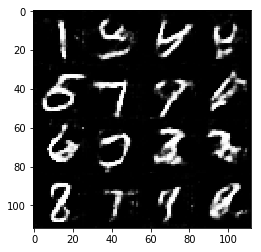

Epoch 2/2... Discriminator Loss: 1.4426... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 1.3803... Generator Loss: 0.7272
Epoch 2/2... Discriminator Loss: 1.4580... Generator Loss: 0.9019
Epoch 2/2... Discriminator Loss: 1.4600... Generator Loss: 0.7224
Epoch 2/2... Discriminator Loss: 1.4707... Generator Loss: 0.7846
Epoch 2/2... Discriminator Loss: 1.4414... Generator Loss: 0.8283
Epoch 2/2... Discriminator Loss: 1.4617... Generator Loss: 0.7113
Epoch 2/2... Discriminator Loss: 1.4835... Generator Loss: 0.7693
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.4690... Generator Loss: 0.7025


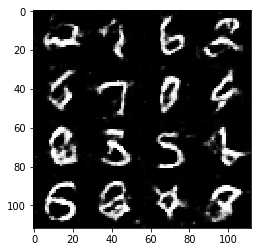

Epoch 2/2... Discriminator Loss: 1.4883... Generator Loss: 0.6522
Epoch 2/2... Discriminator Loss: 1.4372... Generator Loss: 0.7462
Epoch 2/2... Discriminator Loss: 1.4989... Generator Loss: 0.7360
Epoch 2/2... Discriminator Loss: 1.4593... Generator Loss: 0.8882
Epoch 2/2... Discriminator Loss: 1.4353... Generator Loss: 0.8553
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.8475
Epoch 2/2... Discriminator Loss: 1.4327... Generator Loss: 0.7314
Epoch 2/2... Discriminator Loss: 1.4555... Generator Loss: 0.8614
Epoch 2/2... Discriminator Loss: 1.5043... Generator Loss: 0.6588
Epoch 2/2... Discriminator Loss: 1.4232... Generator Loss: 0.8097


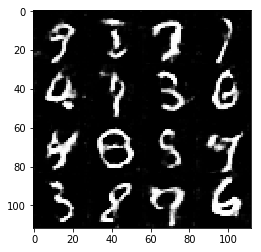

Epoch 2/2... Discriminator Loss: 1.5244... Generator Loss: 0.7722
Epoch 2/2... Discriminator Loss: 1.4123... Generator Loss: 0.7785
Epoch 2/2... Discriminator Loss: 1.4714... Generator Loss: 0.7298
Epoch 2/2... Discriminator Loss: 1.4160... Generator Loss: 0.8212
Epoch 2/2... Discriminator Loss: 1.4306... Generator Loss: 0.7750
Epoch 2/2... Discriminator Loss: 1.4510... Generator Loss: 0.7603
Epoch 2/2... Discriminator Loss: 1.4941... Generator Loss: 0.7250
Epoch 2/2... Discriminator Loss: 1.5071... Generator Loss: 0.7143
Epoch 2/2... Discriminator Loss: 1.4396... Generator Loss: 0.7541
Epoch 2/2... Discriminator Loss: 1.4706... Generator Loss: 0.7255


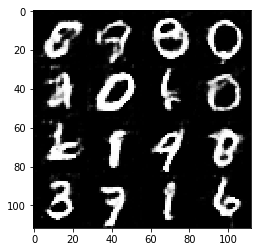

Epoch 2/2... Discriminator Loss: 1.4604... Generator Loss: 0.9066
Epoch 2/2... Discriminator Loss: 1.4920... Generator Loss: 0.7203
Epoch 2/2... Discriminator Loss: 1.4603... Generator Loss: 0.7664
Epoch 2/2... Discriminator Loss: 1.4904... Generator Loss: 0.7318
Epoch 2/2... Discriminator Loss: 1.4848... Generator Loss: 0.7981
Epoch 2/2... Discriminator Loss: 1.4418... Generator Loss: 0.7287
Epoch 2/2... Discriminator Loss: 1.4496... Generator Loss: 0.7833
Epoch 2/2... Discriminator Loss: 1.4923... Generator Loss: 0.7946
Epoch 2/2... Discriminator Loss: 1.5179... Generator Loss: 0.7361
Epoch 2/2... Discriminator Loss: 1.4067... Generator Loss: 0.8756


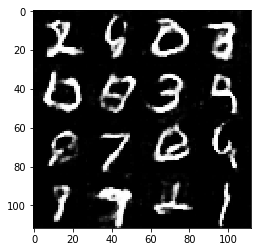

Epoch 2/2... Discriminator Loss: 1.4176... Generator Loss: 0.7795
Epoch 2/2... Discriminator Loss: 1.4754... Generator Loss: 0.8011
Epoch 2/2... Discriminator Loss: 1.4794... Generator Loss: 0.6914
Epoch 2/2... Discriminator Loss: 1.4789... Generator Loss: 0.7422
Epoch 2/2... Discriminator Loss: 1.4772... Generator Loss: 0.7559
Epoch 2/2... Discriminator Loss: 1.4011... Generator Loss: 0.7336
Epoch 2/2... Discriminator Loss: 1.4660... Generator Loss: 0.7332
Epoch 2/2... Discriminator Loss: 1.4215... Generator Loss: 0.6893
Epoch 2/2... Discriminator Loss: 1.4853... Generator Loss: 0.7638
Epoch 2/2... Discriminator Loss: 1.4063... Generator Loss: 0.6930


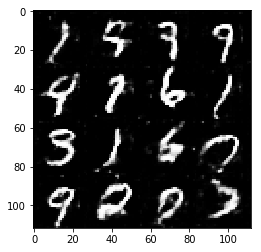

Epoch 2/2... Discriminator Loss: 1.4335... Generator Loss: 0.6657
Epoch 2/2... Discriminator Loss: 1.4408... Generator Loss: 0.7009
Epoch 2/2... Discriminator Loss: 1.4502... Generator Loss: 0.7730
Epoch 2/2... Discriminator Loss: 1.4471... Generator Loss: 0.7741
Epoch 2/2... Discriminator Loss: 1.4745... Generator Loss: 0.6676
Epoch 2/2... Discriminator Loss: 1.3993... Generator Loss: 0.7984
Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.8129
Epoch 2/2... Discriminator Loss: 1.4720... Generator Loss: 0.8458
Epoch 2/2... Discriminator Loss: 1.4539... Generator Loss: 0.8017
Epoch 2/2... Discriminator Loss: 1.4181... Generator Loss: 0.7655


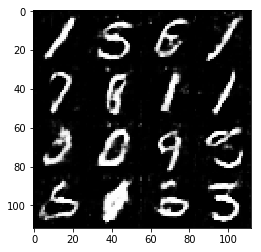

Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 0.6371
Epoch 2/2... Discriminator Loss: 1.4293... Generator Loss: 0.7908
Epoch 2/2... Discriminator Loss: 1.4217... Generator Loss: 0.7059
Epoch 2/2... Discriminator Loss: 1.3953... Generator Loss: 0.8966
Epoch 2/2... Discriminator Loss: 1.4140... Generator Loss: 0.7115
Epoch 2/2... Discriminator Loss: 1.4446... Generator Loss: 0.7425
Epoch 2/2... Discriminator Loss: 1.4060... Generator Loss: 0.8564
Epoch 2/2... Discriminator Loss: 1.4317... Generator Loss: 0.8496
Epoch 2/2... Discriminator Loss: 1.4229... Generator Loss: 0.7382
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 0.8044


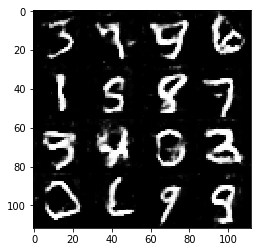

Epoch 2/2... Discriminator Loss: 1.3951... Generator Loss: 0.7223
Epoch 2/2... Discriminator Loss: 1.4171... Generator Loss: 0.7594
Epoch 2/2... Discriminator Loss: 1.4099... Generator Loss: 0.7629
Epoch 2/2... Discriminator Loss: 1.4235... Generator Loss: 0.7044
Epoch 2/2... Discriminator Loss: 1.4058... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 1.3983... Generator Loss: 0.7283
Epoch 2/2... Discriminator Loss: 1.4690... Generator Loss: 0.8176
Epoch 2/2... Discriminator Loss: 1.4195... Generator Loss: 0.8714
Epoch 2/2... Discriminator Loss: 1.4478... Generator Loss: 0.7259
Epoch 2/2... Discriminator Loss: 1.4361... Generator Loss: 0.7391


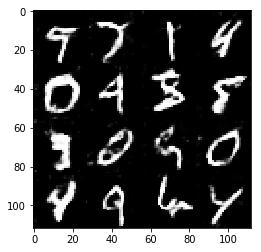

Epoch 2/2... Discriminator Loss: 1.3794... Generator Loss: 0.7713
Epoch 2/2... Discriminator Loss: 1.4548... Generator Loss: 0.7634
Epoch 2/2... Discriminator Loss: 1.3675... Generator Loss: 0.7387
Epoch 2/2... Discriminator Loss: 1.4587... Generator Loss: 0.7433
Epoch 2/2... Discriminator Loss: 1.4541... Generator Loss: 0.7572
Epoch 2/2... Discriminator Loss: 1.4242... Generator Loss: 0.7946
Epoch 2/2... Discriminator Loss: 1.4023... Generator Loss: 0.8025


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.6062... Generator Loss: 0.4143
Epoch 1/1... Discriminator Loss: 1.9749... Generator Loss: 0.4693
Epoch 1/1... Discriminator Loss: 1.6316... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.6287... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.7431... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 1.8141... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.6788... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.5845... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.6391... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.7917... Generator Loss: 0.6096


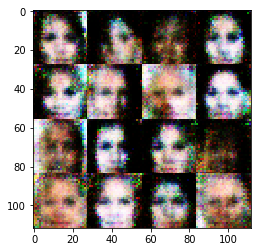

Epoch 1/1... Discriminator Loss: 1.6996... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.9878... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.8692... Generator Loss: 0.4631
Epoch 1/1... Discriminator Loss: 1.8740... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.6918... Generator Loss: 0.5337
Epoch 1/1... Discriminator Loss: 1.7111... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 1.9310... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.8082... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.8233... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.6990... Generator Loss: 0.6181


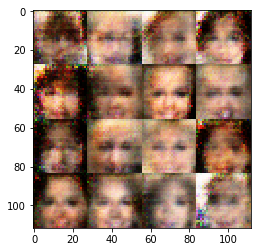

Epoch 1/1... Discriminator Loss: 1.7653... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.8820... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 1.6808... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.7729... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.7388... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.7098... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.7626... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.6058... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.5871... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.6770... Generator Loss: 0.7520


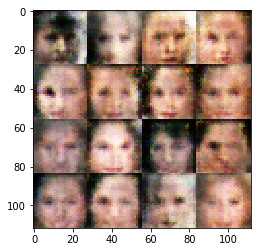

Epoch 1/1... Discriminator Loss: 1.7257... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.5880... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.6102... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.6096... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.7191... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.5760... Generator Loss: 0.7186


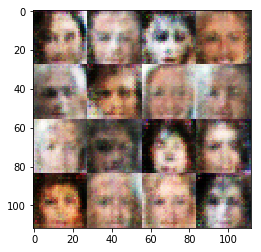

Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.6238... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.7093


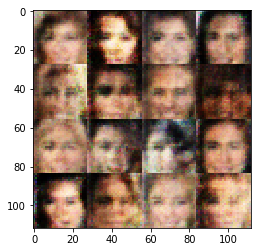

Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.7005


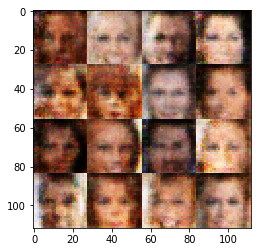

Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 0.7365


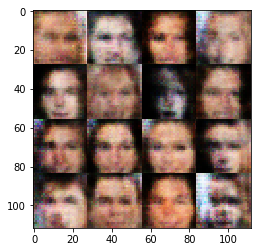

Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.7972


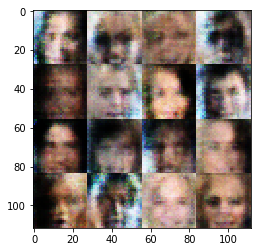

Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.8126


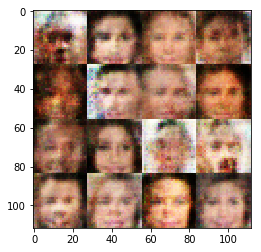

Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7605


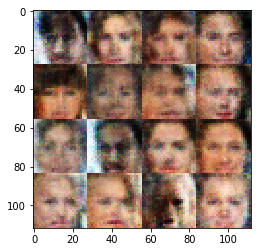

Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.7130


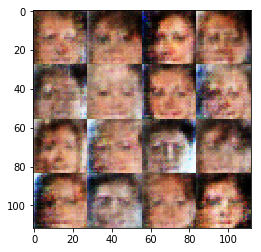

Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.7932


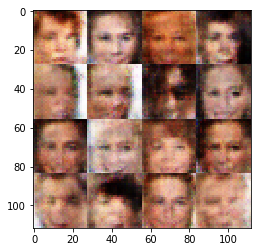

Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6988


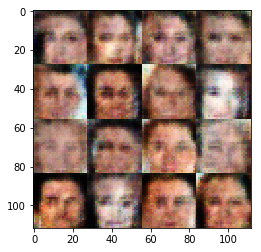

Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7719


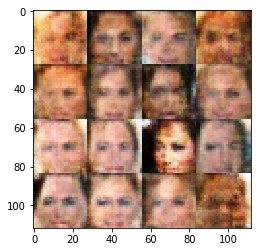

Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.6835


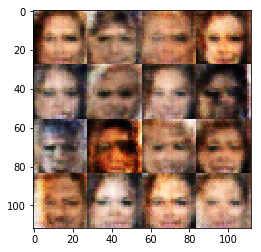

Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7569


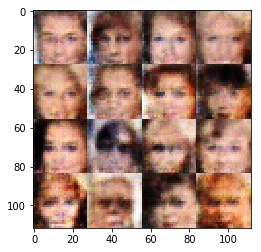

Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.8213


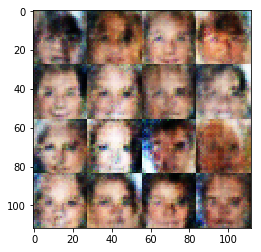

Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7577


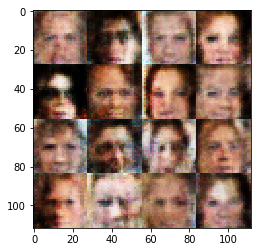

Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7722


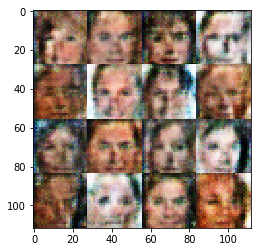

Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.8208


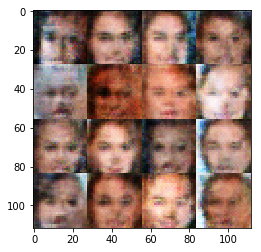

Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7765


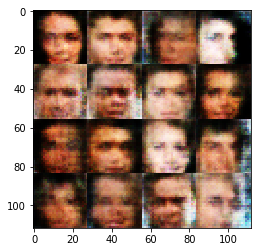

Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7848


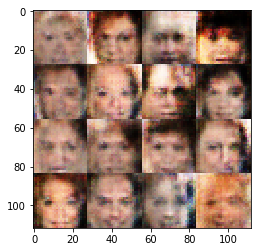

Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.8394


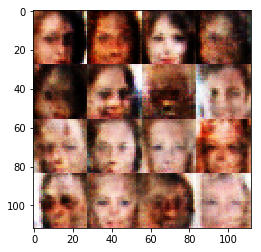

Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7609


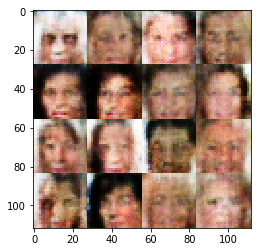

Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.8138


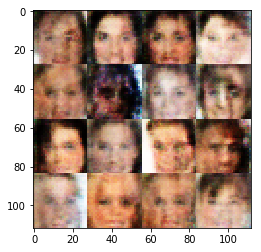

Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.8239


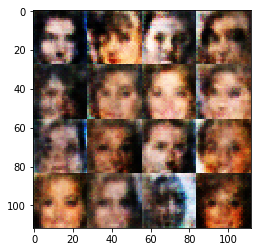

Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7913


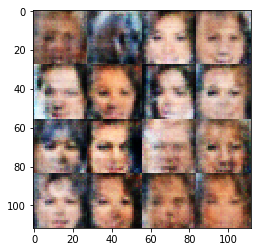

Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7572


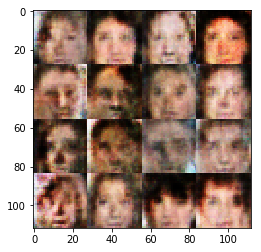

Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7516


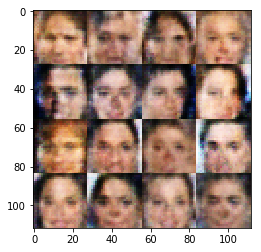

Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.8301


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.